## Dependencias

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from scipy import stats
from sklearn.preprocessing import KBinsDiscretizer


from auxiliares import freq, normalizar
import warnings
warnings.filterwarnings('ignore')
cf.go_offline()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Lectura de datos

In [73]:
df = pd.read_excel('../data/encuesta.xlsx')
df.shape

(2098, 36)

## Universo de trabajo

In [74]:
df = df[df['¿A qué carrera ingresaste?'].isin(
    ['Actuaría', 'Matemáticas Aplicadas y Computación'])].reset_index(drop=True)

df['target'] = (df['¿A qué carrera ingresaste?']=='Actuaría').astype(int)
df.shape


(506, 37)

In [75]:
freq(df,'target')

****Tabla de frecuencias  target  ***


    FA        FR  FAA       FRA
0  283  0.559289  283  0.559289
1  223  0.440711  506  1.000000






## Caracterización de las variables

In [76]:
pd.Series(df.columns).to_clipboard(index=False)

In [77]:
df['id_alumno'] = df.index+1

In [78]:
# Lista de variables continuas
varc = ['¿Cuántos años tienes? 🎂', '¿Qué tanto evitaste que tu carrera tuviera matemáticas?', '¿Qué promedio obtuviste en el bachillerato?', 'Si tuvieras que volver a clases presenciales ¿Cuánto tiempo tardarías en minutos en llegar a la FES Acatlán? ⏱', '¿Cuánto gastarías de pasaje / gasolina a la semana?', '¿A cuánto asciende el ingreso mensual neto de todas las personas que trabajan y viven contigo?', '¿Cuántas personas viven contigo?', '¿Cuántas computadoras hay en tu casa?', 'Hazle un test a tu Internet (ingresando a speedtest.net) y compártenos su velocidad']

# Lista de variables discretas
vard = ['Selecciona tu sexo 👤', '¿Cuál es tu situación sentimental? ❤️', '¿Trabajas? 💼', '¿Tienes hijos? 🍼', 'Esta carrera ¿Fue tu primera opción?', '¿La FES Acatlán fue tu primera opción para cursar esta carrera?', '¿De qué bachillerato provienes?', '¿Qué sistema operativo tiene la computadora que utilizas para estudiar en línea?']

vart = ['target']

um = ['id_alumno']

In [79]:
df = df[um+vart+varc+vard]

## Análisis Exploratorio de Datos

### Discreto

#### Ausentes

In [80]:
for v in vard:
    df[v] = df[v].fillna('MISSING').astype(str)

#### Normalización de variables discretas

In [81]:
freq(df,vard)

****Tabla de frecuencias  Selecciona tu sexo 👤  ***


         FA       FR  FAA      FRA
Hombre  358  0.70751  358  0.70751
Mujer   148  0.29249  506  1.00000




****Tabla de frecuencias  ¿Cuál es tu situación sentimental? ❤️  ***


               FA        FR  FAA       FRA
Soltero       386  0.762846  386  0.762846
Tengo pareja  120  0.237154  506  1.000000




****Tabla de frecuencias  ¿Trabajas? 💼  ***


     FA        FR  FAA       FRA
No  368  0.727273  368  0.727273
Si  138  0.272727  506  1.000000




****Tabla de frecuencias  ¿Tienes hijos? 🍼  ***


     FA        FR  FAA       FRA
No  501  0.990119  501  0.990119
Si    5  0.009881  506  1.000000




****Tabla de frecuencias  Esta carrera ¿Fue tu primera opción?  ***


     FA        FR  FAA       FRA
No   94  0.185771   94  0.185771
Si  412  0.814229  506  1.000000




****Tabla de frecuencias  ¿La FES Acatlán fue tu primera opción para cursar esta carrera?  ***


     FA        FR  FAA       FRA
No   81  0.160079   81  0.16

In [82]:
mapa_norm = list (map(lambda v:normalizar(df,v),vard))

In [83]:
for v,mapa in mapa_norm:
    df[f'n_{v}'] = df[v].replace(mapa)

In [84]:
varn = [f'n_{v}' for v in vard]

In [85]:
freq(df,varn)

****Tabla de frecuencias  n_Selecciona tu sexo 👤  ***


         FA       FR  FAA      FRA
Hombre  358  0.70751  358  0.70751
Mujer   148  0.29249  506  1.00000




****Tabla de frecuencias  n_¿Cuál es tu situación sentimental? ❤️  ***


               FA        FR  FAA       FRA
Soltero       386  0.762846  386  0.762846
Tengo pareja  120  0.237154  506  1.000000




****Tabla de frecuencias  n_¿Trabajas? 💼  ***


     FA        FR  FAA       FRA
No  368  0.727273  368  0.727273
Si  138  0.272727  506  1.000000




****Tabla de frecuencias  n_¿Tienes hijos? 🍼  ***


     FA   FR  FAA  FRA
No  506  1.0  506  1.0




****Tabla de frecuencias  n_Esta carrera ¿Fue tu primera opción?  ***


     FA        FR  FAA       FRA
No   94  0.185771   94  0.185771
Si  412  0.814229  506  1.000000




****Tabla de frecuencias  n_¿La FES Acatlán fue tu primera opción para cursar esta carrera?  ***


     FA        FR  FAA       FRA
No   81  0.160079   81  0.160079
Sí  425  0.839921  506  1.000000





#### Unarias

In [86]:
unarias = [v for v in varn if df[v].nunique()==1]
varn = [v for v in varn if v not in unarias]
df.drop(unarias,axis=1,inplace=True)

### Continuo

#### Discretización de variables continuas

In [87]:
kb = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
kb.fit(df[varc])

KBinsDiscretizer(encode='ordinal')

In [88]:
vardisc = [f'disc_{v}' for v in varc]

In [89]:
df[vardisc] = kb.transform(df[varc]).astype(int)

In [90]:
list(map(len,kb.bin_edges_))

[5, 3, 6, 6, 6, 6, 5, 5, 6]

In [91]:
for v, d in zip(vardisc, map(lambda z: dict(enumerate([f'({t[0]}|{t[1]}]'for t in zip(map(str, z), map(str, z[1:]))])), kb.bin_edges_)):
    df[v] = df[v].replace(d)


In [92]:
freq(df,vardisc)

****Tabla de frecuencias  disc_¿Cuántos años tienes? 🎂  ***


              FA        FR  FAA       FRA
(17.0|18.0]   75  0.148221   75  0.148221
(18.0|19.0]  223  0.440711  298  0.588933
(19.0|20.0]   81  0.160079  379  0.749012
(20.0|30.0]  127  0.250988  506  1.000000




****Tabla de frecuencias  disc_¿Qué tanto evitaste que tu carrera tuviera matemáticas?  ***


            FA        FR  FAA       FRA
(1.0|2.0]  384  0.758893  384  0.758893
(2.0|5.0]  122  0.241107  506  1.000000




****Tabla de frecuencias  disc_¿Qué promedio obtuviste en el bachillerato?  ***


             FA        FR  FAA       FRA
(7.0|7.8]    89  0.175889   89  0.175889
(7.8|8.3]   100  0.197628  189  0.373518
(8.3|8.7]   110  0.217391  299  0.590909
(8.7|9.1]   105  0.207510  404  0.798419
(9.1|10.0]  102  0.201581  506  1.000000




****Tabla de frecuencias  disc_Si tuvieras que volver a clases presenciales ¿Cuánto tiempo tardarías en minutos en llegar a la FES Acatlán? ⏱  ***


                FA       

## Partición

In [93]:
df = df[um+varn+vardisc+vart]

In [94]:
train,valid = train_test_split(df, test_size=0.3)
train.reset_index(drop=True,inplace=True)
valid.reset_index(drop=True,inplace=True)
train.shape, valid.shape

((354, 18), (152, 18))

## Transformación WoE

In [95]:
def transformarWoE(v:str)->dict:
    aux = train[[v]+vart].assign(n=1)
    piv = aux.pivot_table(index=v,columns=vart,values='n',aggfunc='sum',fill_value=0)
    piv/=piv.sum()
    piv['woe'] = np.log(piv[0]/piv[1])
    piv = piv[['woe']]
    return v,piv.to_dict()['woe']

In [96]:
mapa_woe = list(map(transformarWoE,varn+vardisc))
for v,mapa in mapa_woe:
    train[f'woe_{v}'] = train[v].replace(mapa)

In [97]:
varw = [f'woe_{v}' for v in varn+vardisc]

## Calcular poder predictivo

In [109]:
def calcularIV(v:str)->dict:
    aux = train[[v]+vart].assign(n=1)
    piv = aux.pivot_table(index=v,columns=vart,values='n',aggfunc='sum',fill_value=0)
    piv/=piv.sum()
    piv['woe'] = np.log(piv[0]/piv[1])
    piv['iv'] = (piv[0]-piv[1])*piv['woe']
    return v,piv.sum()['iv']

In [110]:
ivr = pd.DataFrame(map(calcularIV,varn+vardisc),columns=['variable','iv']).sort_values('iv',ascending=False)

In [117]:
best = list(ivr[ivr['iv']>0.1]['variable'])
best = [f'woe_{v}' for v in best]

In [118]:
len(best)

6

## Aprendizaje (Regresión Logística) $P = \frac{1}{1+e^{-\theta_0-\vec{\theta}\cdot x}}$

In [119]:
mod = LogisticRegression()
mod.fit(train[best],train['target'])

LogisticRegression()

### $\vec{\theta}$

In [120]:
mod.coef_

array([[-0.57613988, -1.06821923, -0.62439565, -0.99046844, -0.34645851,
        -1.22761161]])

### $\theta_0 = \alpha$

In [130]:
alpha = mod.intercept_[0]

In [121]:
roc_auc_score(train['target'],mod.predict_proba(train[best])[:,1])

0.8914646996838779

## Validación del Modelo

In [123]:
for v,mapa in mapa_woe:
    valid[f'woe_{v}'] = valid[v].replace(mapa)

In [124]:
roc_auc_score(valid['target'],mod.predict_proba(valid[best])[:,1])

0.931948051948052

## Transformación  Scorecard

In [189]:
pdo = 8 # Points to double odds
base = 36 # Base points
base_odds = 1 # Base odds
factor = pdo/np.log(2)
offset = base - factor*np.log(base_odds)
factor,offset


(11.541560327111707, 36.0)

In [220]:
75-39

36

In [190]:
n = len(best)

In [191]:
for v,beta in zip(best,mod.coef_[0]):
    train[f'p_{v}'] = np.floor((-train[v]*beta+alpha/n)*factor+offset/n).astype(int)

In [192]:
varp = [f'p_{v}' for v in best]

In [193]:
train['score'] = train[varp].sum(axis=1)

In [194]:
train['score'].describe()

count    354.000000
mean      34.641243
std       23.506460
min        0.000000
25%       13.000000
50%       34.000000
75%       53.000000
max      100.000000
Name: score, dtype: float64

<Axes: >

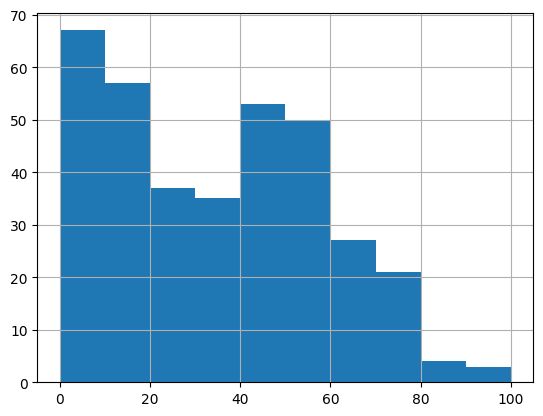

In [195]:
train['score'].hist()

In [196]:
train['r_score'] = pd.cut(train['score'],bins=range(0,120,20),include_lowest=True).astype(str)

In [197]:
freq(train,'r_score')

****Tabla de frecuencias  r_score  ***


                 FA        FR  FAA       FRA
(-0.001, 20.0]  129  0.364407  129  0.364407
(20.0, 40.0]     70  0.197740  199  0.562147
(40.0, 60.0]    104  0.293785  303  0.855932
(60.0, 80.0]     44  0.124294  347  0.980226
(80.0, 100.0]     7  0.019774  354  1.000000






In [200]:
piv = train.pivot_table(index='r_score',columns='target',values='id_alumno',aggfunc='count',fill_value=0)
piv['total'] = piv.sum(axis=1)
piv['actuaría'] = piv[1]/piv['total']
piv['mac'] = piv[0]/piv['total']
piv[['actuaría','mac']].iplot(kind='bar',barmode='stack',title='Distribución de la población por score')


In [216]:
scorecard = []
for v in best:
    nombre  = "_".join(v.split('_')[1:])
    aux = train[[nombre,f'p_{v}']].copy().drop_duplicates().sort_values(by=nombre)
    aux.columns = ['atributo','puntaje']
    aux.insert(0,'característica',"_".join(nombre.split('_')[1:]))
    scorecard.append(aux.reset_index(drop=True))
scorecard = pd.concat(scorecard,ignore_index=True)

In [219]:
scorecard.groupby(['característica','atributo']).sum().to_excel('scorecard.xlsx')